In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats import multitest
import copy

import yaml
import pickle
import sys
sys.path.insert(1, "../code/utils")
sys.path.insert(1, "../code/data_modification")
sys.path.insert(1, "../code/experiment_code")
from experiment_utils import *
from celldata import *
from effects import *
from n_effective import *
from experiment_dumps import *

In [2]:
def FDR_experimentV1(X,n_iter, alpha=0.05, equal_var=True, \
                    mask_model = lambda x: np.zeros((x.shape[0],4)), effect_model=lambda x,y: x,\
                        TAG='UNKNOWN'):
    # data X should have no significant effects (either X is residuals or X has sigificant effects removed)
                                   
    FN_bh = np.zeros(n_iter)
    FP_bh = np.zeros(n_iter)
    rejections_bh = np.zeros(n_iter,dtype=int)
    
    FN_by = np.zeros(n_iter)
    FP_by = np.zeros(n_iter)
    rejections_by = np.zeros(n_iter,dtype=int)
    
    FN_bonf = np.zeros(n_iter,dtype=int)
    FP_bonf = np.zeros(n_iter,dtype=int)
    rejections_bonf = np.zeros(n_iter,dtype=int)
    
    FN_bh_2step = np.zeros(n_iter,dtype=int)
    FP_bh_2step = np.zeros(n_iter,dtype=int)
    rejections_bh_2step = np.zeros(n_iter,dtype=int)

    FN_bky_2step = np.zeros(n_iter,dtype=int)
    FP_bky_2step = np.zeros(n_iter,dtype=int)
    rejections_bky_2step = np.zeros(n_iter,dtype=int)
    
    counts = np.zeros(n_iter,dtype=int)
    n_effects = np.zeros(n_iter,dtype=int)
    
    m0_estimates_bh = np.zeros(n_iter)
    m0_estimates_bky = np.zeros(n_iter)
    
    for i in range(n_iter):
        # make sure that mask function is randomizing the locations of the effects
        mask = mask_model(X)
        true_rejections = compile_pairwise_effect_indicators_legacy(mask)
        
        mask = effect_model(np.zeros_like(X),mask)
        mask = compile_pairwise_comparisons_legacy(mask)
        
        x_perm = compile_pairwise_comparisons_legacy(X)
        rand_inds = np.random.permutation(x_perm.shape[1])
        x_perm = x_perm[:,rand_inds]
        x_perm += mask
        
        n_effects[i] = np.sum(true_rejections)
        
        pvals = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var).pvalue
        counts[i] = len(pvals)
        
        h = multitest.multipletests(pvals, alpha=alpha, method='fdr_bh')[0]
        rejections_bh[i] = np.sum(h)
        FN_bh[i] = false_negatives(h,true_rejections)
        FP_bh[i] = false_positives(h,true_rejections)
        
        h = multitest.multipletests(pvals, alpha=alpha, method='fdr_by')[0]
        rejections_by[i] = np.sum(h)
        FN_by[i] = false_negatives(h,true_rejections)
        FP_by[i] = false_positives(h,true_rejections)
        
        h = multitest.multipletests(pvals, alpha=alpha, method='bonferroni')[0]
        rejections_bonf[i] = np.sum(h)
        FN_bonf[i] = false_negatives(h,true_rejections)
        FP_bonf[i] = false_positives(h,true_rejections)
        
        m0_estimate_bh, alpha_adjusted = estimate_m0_bh(pvals, alpha=alpha, is_sorted=False)
        h = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=False)[0]
        rejections_bh_2step[i] = np.sum(h)
        FN_bh_2step[i] = false_negatives(h,true_rejections)
        FP_bh_2step[i] = false_positives(h,true_rejections)        
        
        m0_estimate_bky, alpha_adjusted = estimate_m0_bky(pvals, alpha=alpha, method='fdr_bh', is_sorted=False)
        h = multitest.multipletests(pvals, alpha=alpha_adjusted, method='fdr_bh', is_sorted=False)[0]
        rejections_bky_2step[i] = np.sum(h)
        FN_bky_2step[i] = false_negatives(h,true_rejections)
        FP_bky_2step[i] = false_positives(h,true_rejections)
        
        m0_estimates_bh[i] = m0_estimate_bh
        m0_estimates_bky[i] = m0_estimate_bky
        
    
    return {'TAG':TAG,'BH':{'FN': FN_bh, 'FP': FP_bh, 'rejections': rejections_bh}, \
            'BY':{'FN': FN_by, 'FP': FP_by, 'rejections': rejections_by}, \
            'BONF':{'FN': FN_bonf, 'FP': FP_bonf, 'rejections': rejections_bonf}, \
            'BH_2STEP':{'FN': FN_bh_2step, 'FP': FP_bh_2step, 'rejections': rejections_bh_2step}, \
            'BKY_2STEP':{'FN': FN_bky_2step, 'FP': FP_bky_2step, 'rejections': rejections_bky_2step}, \
            'n_effects': n_effects, 'n_tests': counts, 'm0_estimates_bh': m0_estimates_bh, 'm0_estimates_bky': m0_estimates_bky}
 

def FDR_experimentV2(X,n_iter, alpha=0.05, equal_var=True, \
                    mask_model = lambda x: np.zeros((x.shape[0],4)), effect_model=lambda x,y: x,\
                        method = 'fdr_bh', th=0.1, TAG='UNKNOWN'):
    # data X should have no significant effects (either X is residuals or X has sigificant effects removed)
    
    FN_fdr_spectral = np.zeros(n_iter)
    FP_fdr_spectral = np.zeros(n_iter)
    rejections_fdr_spectral = np.zeros(n_iter,dtype=int)
    
    FN_fdr_cluster = np.zeros(n_iter)
    FP_fdr_cluster = np.zeros(n_iter)
    rejections_fdr_cluster = np.zeros(n_iter,dtype=int)
                                   
    FN_bonf_spectral = np.zeros(n_iter,dtype=int)
    FP_bonf_spectral = np.zeros(n_iter,dtype=int)
    rejections_bonf_spectral = np.zeros(n_iter,dtype=int)
    
    FN_bonf_cluster = np.zeros(n_iter,dtype=int)
    FP_bonf_cluster = np.zeros(n_iter,dtype=int)
    rejections_bonf_cluster = np.zeros(n_iter,dtype=int)
    
    counts = np.zeros(n_iter,dtype=int)
    n_effects = np.zeros(n_iter,dtype=int)
    M_eff_spectral = np.zeros(n_iter)
    M_eff_cluster = np.zeros(n_iter)
    
    for i in range(n_iter):
        # make sure that mask function is randomizing the locations of the effects
        mask = mask_model(X)
        true_rejections = compile_pairwise_effect_indicators_legacy(mask)
        
        mask = effect_model(np.zeros_like(X),mask)
        mask = compile_pairwise_comparisons_legacy(mask)
        
        x_perm = compile_pairwise_comparisons_legacy(X)
        rand_inds = np.random.permutation(x_perm.shape[1])
        x_perm = x_perm[:,rand_inds]
        x_perm += mask
        
        n_effects[i] = np.sum(true_rejections)
        
        cor = np.corrcoef(x_perm)
        M_eff_spectral[i] = n_eff_spectral_fast(cor, factor=1)
        M_eff_cluster[i] = n_eff_cluster_fast(cor, threshold=th, factor=1)
        
        pvals = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var).pvalue
        counts[i] = len(pvals)
        
        h = (M_eff_spectral[i]*pvals < alpha)        
        rejections_bonf_spectral[i] = np.sum(h)
        FN_bonf_spectral[i] = false_negatives(h,true_rejections)
        FP_bonf_spectral[i] = false_positives(h,true_rejections)
        
        h = (M_eff_cluster[i]*pvals < alpha)
        rejections_bonf_cluster[i] = np.sum(h)
        FN_bonf_cluster[i] = false_negatives(h,true_rejections)
        FP_bonf_cluster[i] = false_positives(h,true_rejections)
         
        h = multitest.multipletests(pvals, alpha=alpha*len(pvals)/M_eff_spectral[i], method=method)[0]
        rejections_fdr_spectral[i] = np.sum(h)
        FN_fdr_spectral[i] = false_negatives(h,true_rejections)
        FP_fdr_spectral[i] = false_positives(h,true_rejections)
        
        h = multitest.multipletests(pvals, alpha=alpha*len(pvals)/M_eff_cluster[i], method=method)[0]
        rejections_fdr_cluster[i] = np.sum(h)
        FN_fdr_cluster[i] = false_negatives(h,true_rejections)
        FP_fdr_cluster[i] = false_positives(h,true_rejections)
        
    return {'TAG':TAG,'FDR_SPECTRAL':{'FN': FN_fdr_spectral, 'FP': FP_fdr_spectral, 'rejections': rejections_fdr_spectral}, \
            'FDR_CLUSTER':{'FN': FN_fdr_cluster, 'FP': FP_fdr_cluster, 'rejections': rejections_fdr_cluster}, \
            'BONF_SPECTRAL':{'FN': FN_bonf_spectral, 'FP': FP_bonf_spectral, 'rejections': rejections_bonf_spectral}, \
            'BONF_CLUSTER':{'FN': FN_bonf_cluster, 'FP': FP_bonf_cluster, 'rejections': rejections_bonf_cluster}, \
            'n_effects': n_effects, 'n_tests': counts, 'M_eff_spectral': M_eff_spectral, 'M_eff_cluster': M_eff_cluster}        


def FDR_experimentV3(X,n_iter, alpha=0.05, equal_var=True, \
                    mask_model = lambda x: np.zeros((x.shape[0],4)), effect_model=lambda x,y: x,\
                        method = 'fdr_bh', combine_method = 'min', th=0.1, TAG='UNKNOWN'):
    # data X should have no significant effects (either X is residuals or X has sigificant effects removed)

    FN = np.zeros(n_iter)
    FP = np.zeros(n_iter)
    rejections = np.zeros(n_iter,dtype=int)
    
    counts = np.zeros(n_iter,dtype=int)
    n_effects = np.zeros(n_iter,dtype=int)
    M_eff = np.zeros(n_iter)
    
    pvalues = np.zeros((n_iter,X.shape[0]*6))
    
    for i in range(n_iter):
        mask = mask_model(X)
        true_rejections = compile_pairwise_effect_indicators_legacy(mask)
        
        mask = effect_model(np.zeros_like(X),mask)
        mask = compile_pairwise_comparisons_legacy(mask)
        
        x_perm = compile_pairwise_comparisons_legacy(X)
        rand_inds = np.random.permutation(x_perm.shape[1])
        x_perm = x_perm[:,rand_inds]
        x_perm += mask
        
        n_effects[i] = np.sum(true_rejections)
        
        cor = np.corrcoef(x_perm)
        cor = n_eff_cluster_fast(cor, threshold = th, method = 'complete', return_labels = True, factor = 1)
        M_eff[i] = cor[0]
        labels = cor[1]
                
        pvals = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var).pvalue
        counts[i] = len(pvals)
        pvals = combine_pvalues(pvals[:,np.newaxis], labels, method = combine_method)
        pvalues[i,:] = pvals.flatten()
        
        h = multitest.multipletests(pvals, alpha=alpha, method=method)[0]
        rejections[i] = np.sum(h)
        FN[i] = false_negatives(h,true_rejections)
        FP[i] = false_positives(h,true_rejections)
        
        method_tag = method.upper() + '_' + combine_method.upper()
        
    return {'TAG':TAG, method_tag: {'FN': FN, 'FP': FP, 'rejections': rejections}, \
            'n_effects': n_effects, 'n_tests': counts, 'M_eff': M_eff, 'pvalues': pvalues}
        
        
    
def FDR_resampling_experimentV1(X,n_iter, n_iter_inner=1000, alpha=0.05, equal_var=True,\
    mask_model = lambda x: np.zeros((x.shape[0],4)), effect_model=lambda x, y: x, TAG='UNKNOWN'):
    # data X should have no significant effects (either X is residuals or X has sigificant effects removed)
        
    FN_wy = np.zeros(n_iter)
    FP_wy = np.zeros(n_iter)
    
    FN_reiner_bh = np.zeros(n_iter)
    FP_reiner_bh = np.zeros(n_iter)
    
    FN_reiner_by = np.zeros(n_iter)
    FP_reiner_by = np.zeros(n_iter)
    
    rejections_wy = np.zeros(n_iter,dtype=int)
    rejections_reiner_bh = np.zeros(n_iter,dtype=int)
    rejections_reiner_by = np.zeros(n_iter,dtype=int)
    
    counts = np.zeros(n_iter,dtype=int)
    n_effects = np.zeros(n_iter,dtype=int)
    
    for i in range(n_iter):
        mask = mask_model(X)
        true_rejections = compile_pairwise_effect_indicators_legacy(mask)
        
        mask = effect_model(np.zeros_like(X),mask)
        mask = compile_pairwise_comparisons_legacy(mask)
        
        x_perm = compile_pairwise_comparisons_legacy(X)
        rand_inds = np.random.permutation(x_perm.shape[1])
        x_perm = x_perm[:,rand_inds]
        x_perm += mask
        
        _, __, resampled_stats, max_stats = westfall_young_resampled_pvalues(x_perm, n_iter=n_iter_inner, equal_var=equal_var)        
        
        n_effects[i] = np.sum(true_rejections)
        
        #pval_wy = np.sort(min_pvals)[int(alpha*n_iter_inner)]
        stat_wy = np.sort(max_stats)[::-1][int(alpha*n_iter_inner)]
        result = stats.ttest_ind(x_perm[:,:10], x_perm[:,10:], axis=1, equal_var=equal_var)
        pvals = result.pvalue
        statistics = result.statistic
        #adjusted_pvals_reiner, adjusted_pvals_marginal = resampling_adjusted_pvalues(pvals, resampled_pvals)
        adjusted_pvals_reiner = resampling_adjusted_pvalues_from_stats(statistics, resampled_stats)
        
        counts[i] = len(pvals)
        #h_wy[i] = (pvals < pval_wy)
        h_wy = (np.abs(statistics) > stat_wy)
        h_reiner_bh = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_bh', is_sorted=False)[0]
        h_reiner_by = multitest.multipletests(adjusted_pvals_reiner, alpha=alpha, method='fdr_by', is_sorted=False)[0]
        
        rejections_wy[i] = np.sum(h_wy)
        rejections_reiner_bh[i] = np.sum(h_reiner_bh)
        rejections_reiner_by[i] = np.sum(h_reiner_by)
        
        FN_wy[i] = false_negatives(h_wy,true_rejections)
        FP_wy[i] = false_positives(h_wy,true_rejections)

        FN_reiner_bh[i] = false_negatives(h_reiner_bh,true_rejections)
        FP_reiner_bh[i] = false_positives(h_reiner_bh,true_rejections)
        
        FN_reiner_by[i] = false_negatives(h_reiner_by,true_rejections)
        FP_reiner_by[i] = false_positives(h_reiner_by,true_rejections)
        
    # return everything in a dictionary
    return {'TAG':TAG,'WY':{'FN': FN_wy, 'FP': FP_wy, 'rejections': rejections_wy}, \
            'REINER_BH':{'FN': FN_reiner_bh, 'FP': FP_reiner_bh, 'rejections': rejections_reiner_bh},\
            'REINER_BY':{'FN': FN_reiner_by, 'FP': FP_reiner_by, 'rejections': rejections_reiner_by},\
            'n_effects': n_effects, 'n_tests': counts}
        
    

In [15]:


def calculate_relevant_measures(result):
    # calculate relevant measures for each method:
    # Sensitivity, Specificity, FDR, FWER, average power, average proportion of rejections to true effects.
    # additionally, for any key with 'M_eff' in it, calculate the average M_eff, and same for 'n_effects',
    # and anything with 'm0' in it, calculate the average m0 estimate (use same keys as in the result dictionary)
    # This is the structure of the result dictionary
    '''
    {'TAG':TAG,'WY':{'FN': FN_wy, 'FP': FP_wy, 'rejections': rejections_wy}, \
            'REINER_BH':{'FN': FN_reiner_bh, 'FP': FP_reiner_bh, 'rejections': rejections_reiner_bh},\
            'REINER_BY':{'FN': FN_reiner_by, 'FP': FP_reiner_by, 'rejections': rejections_reiner_by},\
            'n_effects': n_effects, 'n_tests': counts}
    '''
    measures = {}
    m1 = result['n_effects']
    m = result['n_tests']
    m0 = m - m1
    for key in result.keys():
        if key == 'TAG':
            # add tag to measures
            measures['TAG'] = result['TAG']
        # if the value is a dictionary, then we need to calculate the measures
        # We know there are always FN, FP, and rejections
        elif isinstance(result[key],dict):
            FN = result[key]['FN']
            V = FP = result[key]['FP']
            R = result[key]['rejections']
            S = TP = R - FP
            TN = m - R - FN
            # make a dictionary to store the measures with the same keys as the result dictionary
            measures[key] = {}
            measures[key]['Sensitivity'] = np.mean(TP/(TP+FN))  
            measures[key]['Specificity'] = np.mean(TN/(TN+FP))
            FDP = [v/r if r > 0 else 0 for v,r in zip(V,R)]
            measures[key]['FDR'] = np.mean(FDP)
            measures[key]['FDP_var'] = np.var(FDP)
            measures[key]['FWER'] = np.mean(V>=1)
            measures[key]['Average_Power'] = np.mean(S/m1)
            # accuracy is proportion of correctly assigned tests
            measures[key]['Accuracy'] = np.mean((TP+TN)/m)
            measures[key]['Average_Proportion_Rejections'] = np.mean(R/m1)

        # if the value is an array, then we need to calculate the average
        elif isinstance(result[key],np.ndarray):
            # if the key has 'M_eff' in it, then calculate the average M_eff
            if 'M_eff' in key:
                new_key = key + '_average_proportion'
                measures[new_key] = np.mean(result[key]/m)
            if 'm0' in key:
                new_key = key + '_average_proportion'
                measures[new_key] = np.mean(result[key]/m0)
                        
    return measures

def print_relevant_measures(measures):
    for key in measures.keys():
        if isinstance(measures[key],dict):
            print(key)
            for k in measures[key].keys():
                print(k,measures[key][k])
        else:
            print(key,measures[key])
            if key == 'TAG':
                print()
            
            

def save_relevant_measures(measures, filename):
    with open(filename, 'w') as f:
        for key in measures.keys():
            if isinstance(measures[key],dict):
                f.write(key + '\n')
                for k in measures[key].keys():
                    f.write(k + ' ' + str(measures[key][k]) + '\n')
            else:
                f.write(key + ' ' + str(measures[key]) + '\n')


In [3]:
pathIN = "../data/modified_data/"
filenames = [line.split('\n')[0] for line in open(pathIN + "filenames.txt")]
for i in  range(len(filenames)):print(filenames[i])

MOD_cellshilicnegGFstatus.csv
MOD_cellshilicposGFstatus.csv
MOD_cellslipidnegGFstatus.csv
MOD_cellslipidposGFstatus.csv
MOD_cellsRPnegGFstatus.csv
MOD_cellsRPposGFstatus.csv
RESIDUALS_cellshilicnegGFstatus.csv
RESIDUALS_cellshilicposGFstatus.csv
RESIDUALS_cellslipidnegGFstatus.csv
RESIDUALS_cellslipidposGFstatus.csv
RESIDUALS_cellsRPnegGFstatus.csv
RESIDUALS_cellsRPposGFstatus.csv





In [4]:
fnum=6
fname = filenames[fnum]
data = pd.read_csv(pathIN + fname, sep=";")
area = data.iloc[:, :40].to_numpy()
gaps = data.iloc[:, 40:].to_numpy()
print(fname)

RESIDUALS_cellshilicnegGFstatus.csv


In [5]:
area.shape[0]*0.05*6

39.300000000000004

In [25]:
#np.random.seed(0)
#effect_model = lambda x, y: insert_abramovich_shifts_legacy(x, y, r=1.5, p=1)
effect_model = lambda x, y: insert_model_shifts_legacy(x, y, shift_model=lambda: 1)
mask_model = lambda x: generate_random_effect_maskV2(x.shape[0], 0.05*6, [1], lambda: 1 if np.random.rand() < 0.5 else -1, randomize_rows=True)

result= FDR_experimentV1(area, n_iter=1000, alpha=0.05, \
    equal_var=True,mask_model=mask_model, effect_model=effect_model)

In [19]:
#np.random.seed(0)
#effect_model = lambda x, y: insert_abramovich_shifts_legacy(x, y, r=1.5, p=1)
effect_model = lambda x, y: insert_model_shifts_legacy(x, y, shift_model=lambda: 1)
mask_model = lambda x: generate_random_effect_maskV2(x.shape[0], 0.05*6, [1], lambda: 1 if np.random.rand() < 0.5 else -1, randomize_rows=True)

result= FDR_experimentV2(area, n_iter=1000, alpha=0.05, \
    equal_var=True,mask_model=mask_model, effect_model=effect_model, method='fdr_bh', th=0.05)

In [26]:
result = FDR_resampling_experimentV1(area, n_iter=1000, n_iter_inner=1000, alpha=0.05, equal_var=True, mask_model=mask_model, effect_model=effect_model)

In [18]:
measures = calculate_relevant_measures_general(result)
print_relevant_measures(measures)

n_effects_average 39.0
n_tests_average 786.0
m0_average 747.0
TAG UNKNOWN

FDR_SPECTRAL
Sensitivity 0.512051282051282
Specificity 0.9980589022757698
FDR 0.03727406839891975
FDP_var 0.011480673465069226
FWER 0.22
Average_Power 0.512051282051282
Accuracy 0.9739440203562342
Average_Proportion_Rejections 0.5492307692307692
FDR_CLUSTER
Sensitivity 0.54
Specificity 0.9966934404283802
FDR 0.06316899173642632
FDP_var 0.017503352836333832
FWER 0.36
Average_Power 0.54
Accuracy 0.9740330788804072
Average_Proportion_Rejections 0.6033333333333334
BONF_SPECTRAL
Sensitivity 0.3600000000000001
Specificity 0.9998393574297189
FDR 0.0048874722302714195
FDP_var 0.0008970185262326237
FWER 0.04
Average_Power 0.3600000000000001
Accuracy 0.9680916030534351
Average_Proportion_Rejections 0.36307692307692313
BONF_CLUSTER
Sensitivity 0.377948717948718
Specificity 0.9998259705488621
FDR 0.005239439103977423
FDP_var 0.0009728835662059819
FWER 0.04
Average_Power 0.377948717948718
Accuracy 0.9689694656488547
Average_

In [14]:
measures = calculate_relevant_measures_general(result)
print_relevant_measures(measures)    

n_effects_average 39.0
n_tests_average 786.0
m0_average 747.0
TAG UNKNOWN

FDR_SPECTRAL
Sensitivity 0.504102564102564
Specificity 0.9984069611780455
FDR 0.03516323225742464
FDP_var 0.010125087673249369
FWER 0.22
Average_Power 0.504102564102564
Accuracy 0.9738804071246819
Average_Proportion_Rejections 0.5346153846153847
FDR_CLUSTER
Sensitivity 0.5494871794871795
Specificity 0.996532797858099
FDR 0.0659460839988816
FDP_var 0.01775303498920998
FWER 0.39
Average_Power 0.5494871794871795
Accuracy 0.9743511450381681
Average_Proportion_Rejections 0.615897435897436
BONF_SPECTRAL
Sensitivity 0.36282051282051286
Specificity 0.9998259705488621
FDR 0.005
FDP_var 0.0024749999999999998
FWER 0.01
Average_Power 0.36282051282051286
Accuracy 0.9682188295165395
Average_Proportion_Rejections 0.3661538461538461
BONF_CLUSTER
Sensitivity 0.3912820512820513
Specificity 0.9997590361445784
FDR 0.006658119658119659
FDP_var 0.0028901496822266053
FWER 0.03
Average_Power 0.3912820512820513
Accuracy 0.96956743002544

In [55]:
calculate_relevant_measures(result)

{'TAG': 'UNKNOWN',
 'BH': {'Sensitivity': 0.43820915032679736,
  'Specificity': 0.998505376344086,
  'FDR': 0.03820649503228693,
  'FDP_var': 0.006884077902635086,
  'FWER': 0.539,
  'Average_Power': 0.43820915032679736,
  'Accuracy': 0.9702691040843215,
  'Average_Proportion_Rejections': 0.46637254901960784},
 'BY': {'Sensitivity': 0.2843071895424837,
  'Specificity': 0.9998324661810614,
  'FDR': 0.005405151000537511,
  'FDP_var': 0.0013339428628392584,
  'FWER': 0.093,
  'Average_Power': 0.2843071895424837,
  'Accuracy': 0.9637733860342557,
  'Average_Proportion_Rejections': 0.2874640522875817},
 'BONF': {'Sensitivity': 0.2122287581699346,
  'Specificity': 0.9999719042663892,
  'FDR': 0.0017448202129872214,
  'FDP_var': 0.0002890297537504616,
  'FWER': 0.029,
  'Average_Power': 0.2122287581699346,
  'Accuracy': 0.9602733860342556,
  'Average_Proportion_Rejections': 0.21275816993464053},
 'BH_2STEP': {'Sensitivity': 0.4408039215686275,
  'Specificity': 0.9983773846687477,
  'FDR': 0.0

In [29]:
result= FDR_experimentV2(area, n_iter=1000, alpha=0.05, \
    equal_var=True,mask_model=mask_model, effect_model=effect_model)

In [9]:
result.keys()

dict_keys(['TAG', 'BH', 'BY', 'BONF', 'BH_2STEP', 'BKY_2STEP', 'n_effects', 'counts', 'm0_estimates_bh', 'm0_estimates_bky'])

In [7]:
print_ERROR_and_POWER(result['BH']['FP'], result['BH']['rejections'], result['n_effects'])

FWER: 0.124, FDR: 0.030303948487368858, POWER: 0.444


In [9]:
# print the average number of discoveries
print(result['rejections_fdr_spectral'].mean())
print(result['rejections_fdr_cluster'].mean())
print(result['rejections_bonf_spectral'].mean())

5.08
5.46
5.26


In [17]:
#np.random.seed(0)
#effect_model = lambda x, y: insert_abramovich_shifts_legacy(x, y, r=1.5, p=1)
mask_model = lambda x: generate_random_effect_maskV2(x.shape[0], 0.1, [1], lambda: 1 if np.random.rand() < 0.5 else -1, randomize_rows=True)
#scale_model = lambda x: randomly_scale_groups_legacy(x, lambda: 1 + np.random.uniform(-0.5,0.5))
scale_model = None
effect_model = lambda x, y: insert_model_shifts_legacy(x, y, shift_model=lambda: 1.0)
result= FDR_experimentV3(area, n_iter=100, alpha=0.05, filter=None, \
    equal_var=True,mask_model=mask_model, effect_model=effect_model, \
        scale_model=scale_model, method = 'fdr_bh', combine_method='harmonic', th=0.01)

In [21]:
result= FDR_experimentV3(area, n_iter=500, alpha=0.05, filter=None, \
    equal_var=True, method = 'fdr_bh', combine_method='harmonic', th=0.01)

In [22]:
result['M_eff'].mean()

591.368

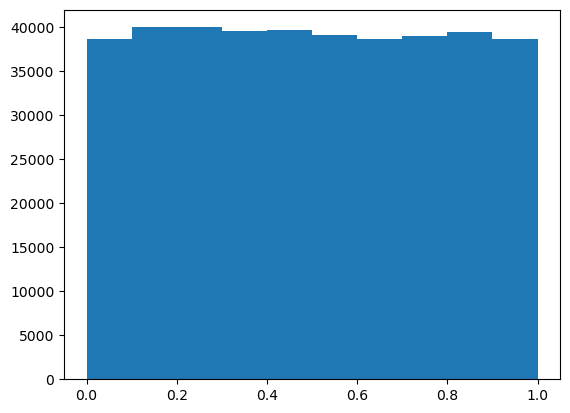

In [23]:
plt.hist(result['pvalues'].flatten())
plt.show()

In [24]:
k=20
orderstats = np.sort(result['pvalues'], axis=1)
orderstats.shape

(500, 786)

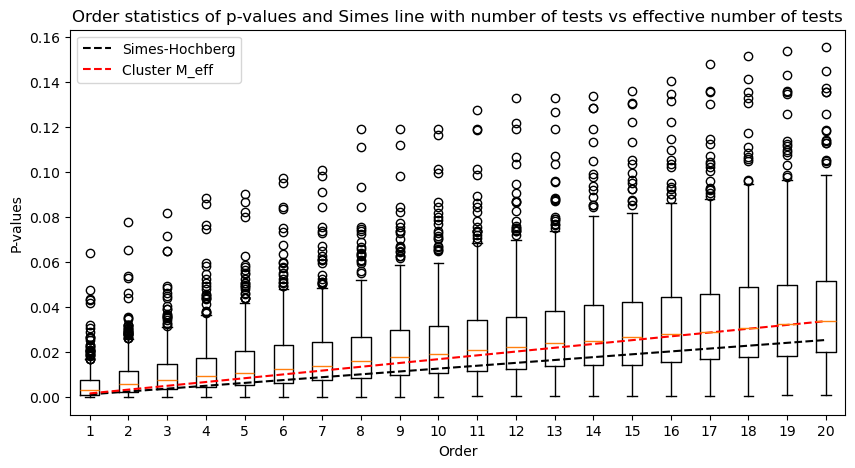

In [25]:
# plot boxplots of order statistics
plt.figure(figsize=(10,5))
plt.boxplot(orderstats[:,:k])
plt.xlabel('Order')
plt.ylabel('P-values')
plt.plot(np.arange(1,k+1), np.arange(1,k+1)/orderstats.shape[1], color='black', linestyle='--', label='Simes-Hochberg')
plt.plot(np.arange(1,k+1), np.arange(1,k+1)/result['M_eff'].mean(), color='red', linestyle='--', label='Cluster M_eff')
plt.title('Order statistics of p-values and Simes line with number of tests vs effective number of tests')
plt.legend()
plt.show()

In [199]:
print_ERRORS_and_POWER(result['FP'], result['rejections'], result['n_effects'])

FDR: 0.042000, FWER: 0.042000, Power: nan


c:\Users\paavo\Tiedostot\PARKINSONS\PDproj\paavothesis\notebooks\../code/data_modification\effects.py:392: RuntimeWarning: invalid value encountered in divide
  power = tp/n_effects


In [ ]:
'''
'FN_bh_neff': FN_bh, 'FP_bh_neff': FP_bh, 'rejections_bh_neff': rejections_bh, \
            'FN_by_neff': FN_by, 'FP_by_neff': FP_by, 'rejections_by_neff': rejections_by, \
            'FN_bonf_neff': FN_bonf, 'FP_bonf_neff': FP_bonf, 'rejections_bonf_neff': rejections_bonf, \
            'n_effects': n_effects, 'counts': counts, 'M_eff': M_eff
'''

In [29]:
np.mean(result['FP_bh_neff']>=1), np.mean(result['FP_by_neff']>=1), np.mean(result['FP_bonf_neff']>=1)

(0.1526, 0.0222, 0.0202)

In [114]:
np.mean(result['FP_bh']>=1), np.mean(result['FP_by']>=1), np.mean(result['FP_bonf']>=1), np.mean(result['FP_bh_2step']>=1), np.mean(result['FP_bky_2step']>=1)

(0.1251, 0.0192, 0.0182, 0.1267, 0.1264)

In [115]:
result['n_effects'].max(), result['n_effects'].mean(), result['n_effects'].min()

(18, 18.0, 18)

In [116]:
print_FDR_and_POWER(result['FP_bh'], result['rejections_bh'], result['n_effects'])
print_FDR_and_POWER(result['FP_by'], result['rejections_by'], result['n_effects'])
print_FDR_and_POWER(result['FP_bonf'], result['rejections_bonf'], result['n_effects'])
print_FDR_and_POWER(result['FP_bh_2step'], result['rejections_bh_2step'], result['n_effects'])
print_FDR_and_POWER(result['FP_bky_2step'], result['rejections_bky_2step'], result['n_effects'])

0.03015534163549807 0.4178444444444444
0.004526639710306893 0.3085333333333333
0.004800277402715558 0.31750555555555554
0.030912516795601884 0.41866111111111115
0.03053308318730151 0.41842777777777784


In [13]:
#np.random.seed(1)
#effect_model = lambda x, y: insert_abramovich_shifts_legacy(x, y, r=1.5, p=1)
#effect_model = lambda x, y: insert_model_shifts_legacy(x, y, shift_model=lambda: 5)
#mask_model = lambda x: generate_random_effect_maskV2(x.shape[0], 16, [1], lambda: 1 if np.random.rand() < 0.5 else -1, randomize_rows=True)
result= FDR_resampling_experimentV1(area, n_iter=100, n_iter_inner=100, alpha=0.05, filter=variance_filter_inds(0,'prop'), \
    equal_var=True, effect_model=effect_model, mask_model=mask_model, scale_model=scale_model, full_resampling=False)

In [14]:
result.keys()


dict_keys(['TAG', 'WY', 'REINER_BH', 'REINER_BY', 'n_effects', 'counts'])

In [19]:
np.mean(result['WY']['FP']>=1), np.mean(result['WY']['FP']>=1), np.mean(result['REINER_BH']['FP']>=1)

(0.05, 0.05, 0.15)

In [20]:
print_ERROR_and_POWER(result['REINER_BH']['FP'],result['REINER_BH']['rejections'],result['n_effects'])

FWER: 0.15, FDR: 0.03761913086913087, POWER: 0.4516666666666667


In [18]:
np.mean(result['REINER_BH']['FP']>=1), np.mean(result['REINER_BH']['FP']>=1), np.mean(result['WY']['FP']>=1)

(0.15, 0.15, 0.05)

In [140]:
print_FDR_and_POWER(result['FP_wy'], result['rejections_wy'], result['n_effects'])
print_FDR_and_POWER(result['FP_reiner_bh'], result['rejections_reiner_bh'], result['n_effects'])
print_FDR_and_POWER(result['FP_reiner_by'], result['rejections_reiner_by'], result['n_effects'])

0.010428571428571428 0.3466666666666666
0.04372908373875866 0.41444444444444434
0.0025 0.2994444444444444
